# Analyzing Time-series Data with FTGPs

We use time-series decomposition to try to explain/analyze the quality of our FTGPs. Time-series decomposition helps us break down a time-series dataset into three main components:

**1. Trend:** The trend component represents the long-term movement in the data, representing the underlying pattern.

**2. Seasonality:** The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.

**3. Residual (Noise):** The residual component represents random variability that remains after removing the trend and seasonality.

By separating these components, we can gain insights into the behavior of the data and make better forecasts. 

### Types of Time Series Decomposition Techniques

**a) Additive Decomposition**

* In additive decomposition, the time series is expressed as the sum of its components. It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

**b) Multiplicative Decomposition**

* In multiplicative decomposition, the time series is expressed as the product of its components.It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

$$Y(t) = Trend(t) * Seasonal(t) * Residual(t)$$

### Methods of Decomposition
**a) Moving Averages**

* Moving averages involve calculating the average of a certain number of past data points. It helps smooth out fluctuations and highlight trends.

**b) Seasonal Decomposition of Time Series**

* The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.

**c) Exponential Smoothing State Space Model**

* This method involves using the ETS framework to estimate the trend and seasonal components in a time series.

### Reference
* https://www.geeksforgeeks.org/time-series-decomposition-techniques/


## Import Libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

## Import from local directory
import sys
sys.path.insert(0, '../src')
from TemporalGP.TGP.tgrad_ami import TGradAMI

Configure TGradAMI algorithm hyperparameters.

In [2]:
# Hyperparameters

# f_path = "../datasets/air_quality1k.csv"
# f_path = "../datasets/rain_temp2013-2015.csv"
# f_path = ".../datasets/ndvi/average_evi_mak.csv"
f_path = "../datasets/ke_rain_data_2k.csv"
eq = False
min_sup = 0.5
tgt_col = 1
min_rep = 0.75
mi_err_margin = 0.0001
eval_mode = True
clustering_method = False

Visualize top 5 rows of the dataset.

In [3]:
data = pd.read_csv(f_path)
data.head()
# data[[' NRB (mm)']]

,Date (Jul-Sep),NRB (mm),KAK (mm),MAK (mm),WAJ (mm)
0,07-2000,22.01000,526.8000,18.45,12.219990
1,07-2001,57.55001,539.0801,0.90,13.440000
2,07-2002,45.17000,349.2700,20.47,15.320000
3,07-2003,77.08001,660.0199,2.27,8.940001
4,07-2004,16.48000,424.6999,0.71,4.819999


Initialize TGradAMI algorithm by creating an object.

In [4]:
t_grad = TGradAMI(f_path, min_sup, eq, target_col=tgt_col, min_rep=min_rep, min_error=mi_err_margin)


Dataset Ok


Run the algorithm for mining FTGPs (Fuzzy Temporal Gradual Patterns) in evaluation mode. The algorithm returns a number of results in a dict format. The decomposed gradual pattern components is also returned. This GP components can be used in analyzing multiple timeseries.

In [5]:
eval_dict = t_grad.discover_tgp(use_clustering=clustering_method, eval_mode=eval_mode)
list_tgp = t_grad.gradual_patterns
trans_data = eval_dict['Transformed Data']
time_data = eval_dict['Time Data']
gp_components = eval_dict['GP Components']
#gp_components

## Approach 1: Timeseries Decomposition using Classical Approach

We decompose our timeseries data into additive Trend + Seasonal components.

* We first create a Datetime index for each timeseries data.

In [6]:
# t_grad.data[:, tgp.attr_cols[0]]
t_grad.data[:, t_grad.time_cols[0]]

array(['07-2000', '07-2001', '07-2002', '07-2003', '07-2004', '07-2005',
       '07-2006', '07-2007', '07-2008', '07-2009', '07-2010', '07-2011',
       '07-2012', '07-2013', '07-2014', '07-2015', '07-2016', '07-2017',
       '07-2018', '07-2019', '07-2020', '07-2021', '07-2022'],
      dtype=object)

In [7]:
time_arr = t_grad.data[:, t_grad.time_cols[0]]
datetime_series = pd.to_datetime(time_arr, format='%m-%Y')
datetime_index = pd.DatetimeIndex(datetime_series)
#datetime_index

* We create a Pandas timeseries for eact attribute of our dataset.

In [8]:
lst_ts = []
lst_titles = []
for col in t_grad.attr_cols:
    ts = pd.Series(t_grad.data[:, col].astype(float), index=datetime_index)
    lst_titles.append(t_grad.titles[col][1].decode())
    lst_ts.append(ts)

* We plot the timeseries in order to visualize it.

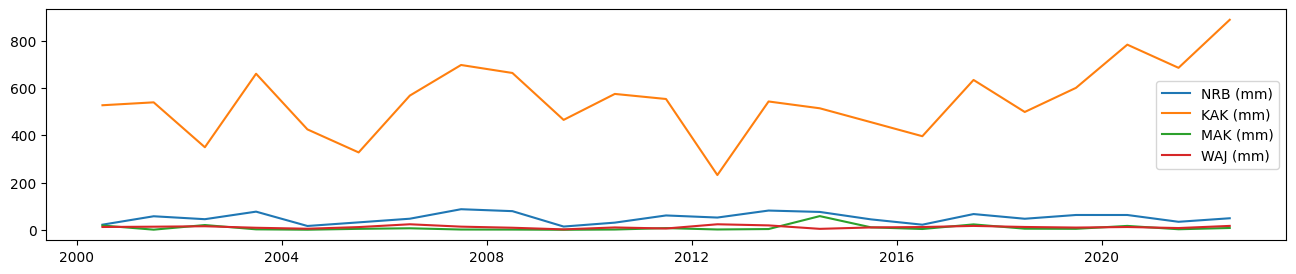

In [9]:
plt.figure(figsize=(16,3))
for i in range(len(lst_ts)):
    plt.plot(datetime_index, lst_ts[i], label=lst_titles[i])
plt.legend()

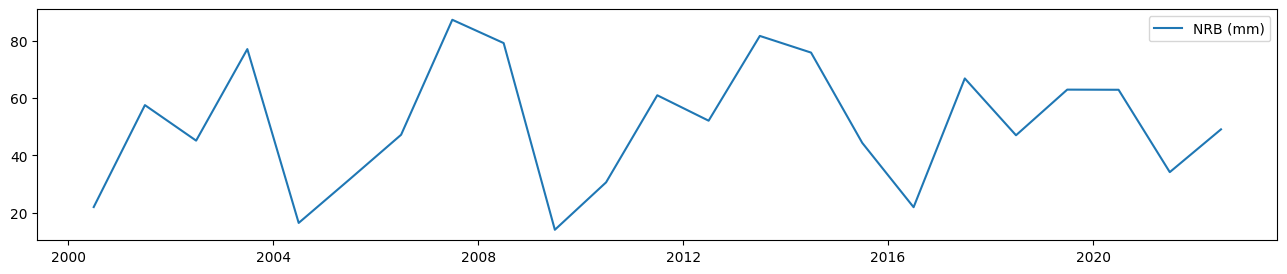

In [10]:
plt.figure(figsize=(16,3))
plt.plot(lst_ts[0], label=lst_titles[0])
plt.legend()

* We perform **Additive Timeseries Decomposition**.

In [11]:
lst_compts = []
for ts in lst_ts:
    compt = seasonal_decompose(ts, model='additive')
    lst_compts.append(compt)


* We visualize the **Trend Component**

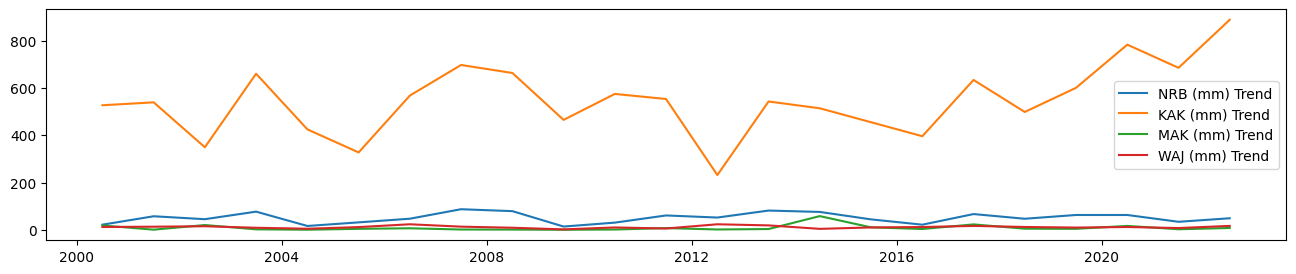

In [12]:
plt.figure(figsize=(16, 3))
for i in range(len(lst_compts)):
    plt.plot(datetime_index, lst_compts[i].trend, label=f"{lst_titles[i]} Trend")
plt.legend()

* We visualize the **Seasonal Component**

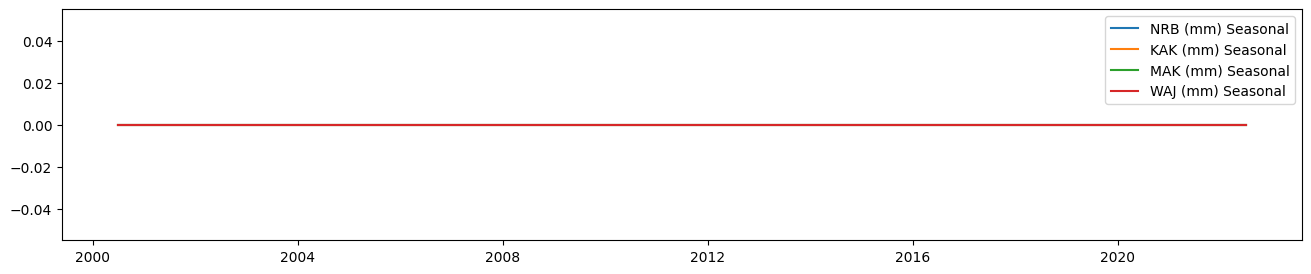

In [13]:
plt.figure(figsize=(16, 3))
for i in range(len(lst_compts)):
    plt.plot(datetime_index, lst_compts[i].seasonal, label=f"{lst_titles[i]} Seasonal")
plt.legend()

## Approach 2: Multiple Timeseries Decomposition using FTGPs

We can use FTGPs to decompose the pairwise object pairs gradual items (GIs) or gradual patterns (GPs) (which are associated to specific attributes/timeseries) into a single scale *warping path* that will allow us to accurately measure the gradual similarity of different timeseries datasets.

* We can visualize the GIs or GPs as shown below.

In [ ]:
# Alternative Method (instead of using TGradAMI class)
# import so4gp as sgp
# gp_components = sgp.gradual_component(f_path, target_col=tgt_col)

In [14]:
gp_components.keys()
#gp_components.items()

dict_keys(['1+', '1-', '2+', '2-', '3+', '3-', '4+', '4-', "['1+', ['(2-) +12.0 months']]", "['1+', ['(3-) +5.0 years']]", "['1+', ['(4-) +12.0 months']]", "['1-', ['(2+) +12.0 months']]", "['1-', ['(3+) +5.0 years']]", "['1-', ['(4+) +12.0 months']]"])

In [15]:
warping_path = gp_components['1+']

* We draw numerous plots to visualize the multiple timeseries decompositions using FTGPs. Timeseries data that have strong correlation will produce a decomposition graph with dense zigzag patterns. Those with weak correlation will produce a decomposition graph with sparse zigzag patterns.

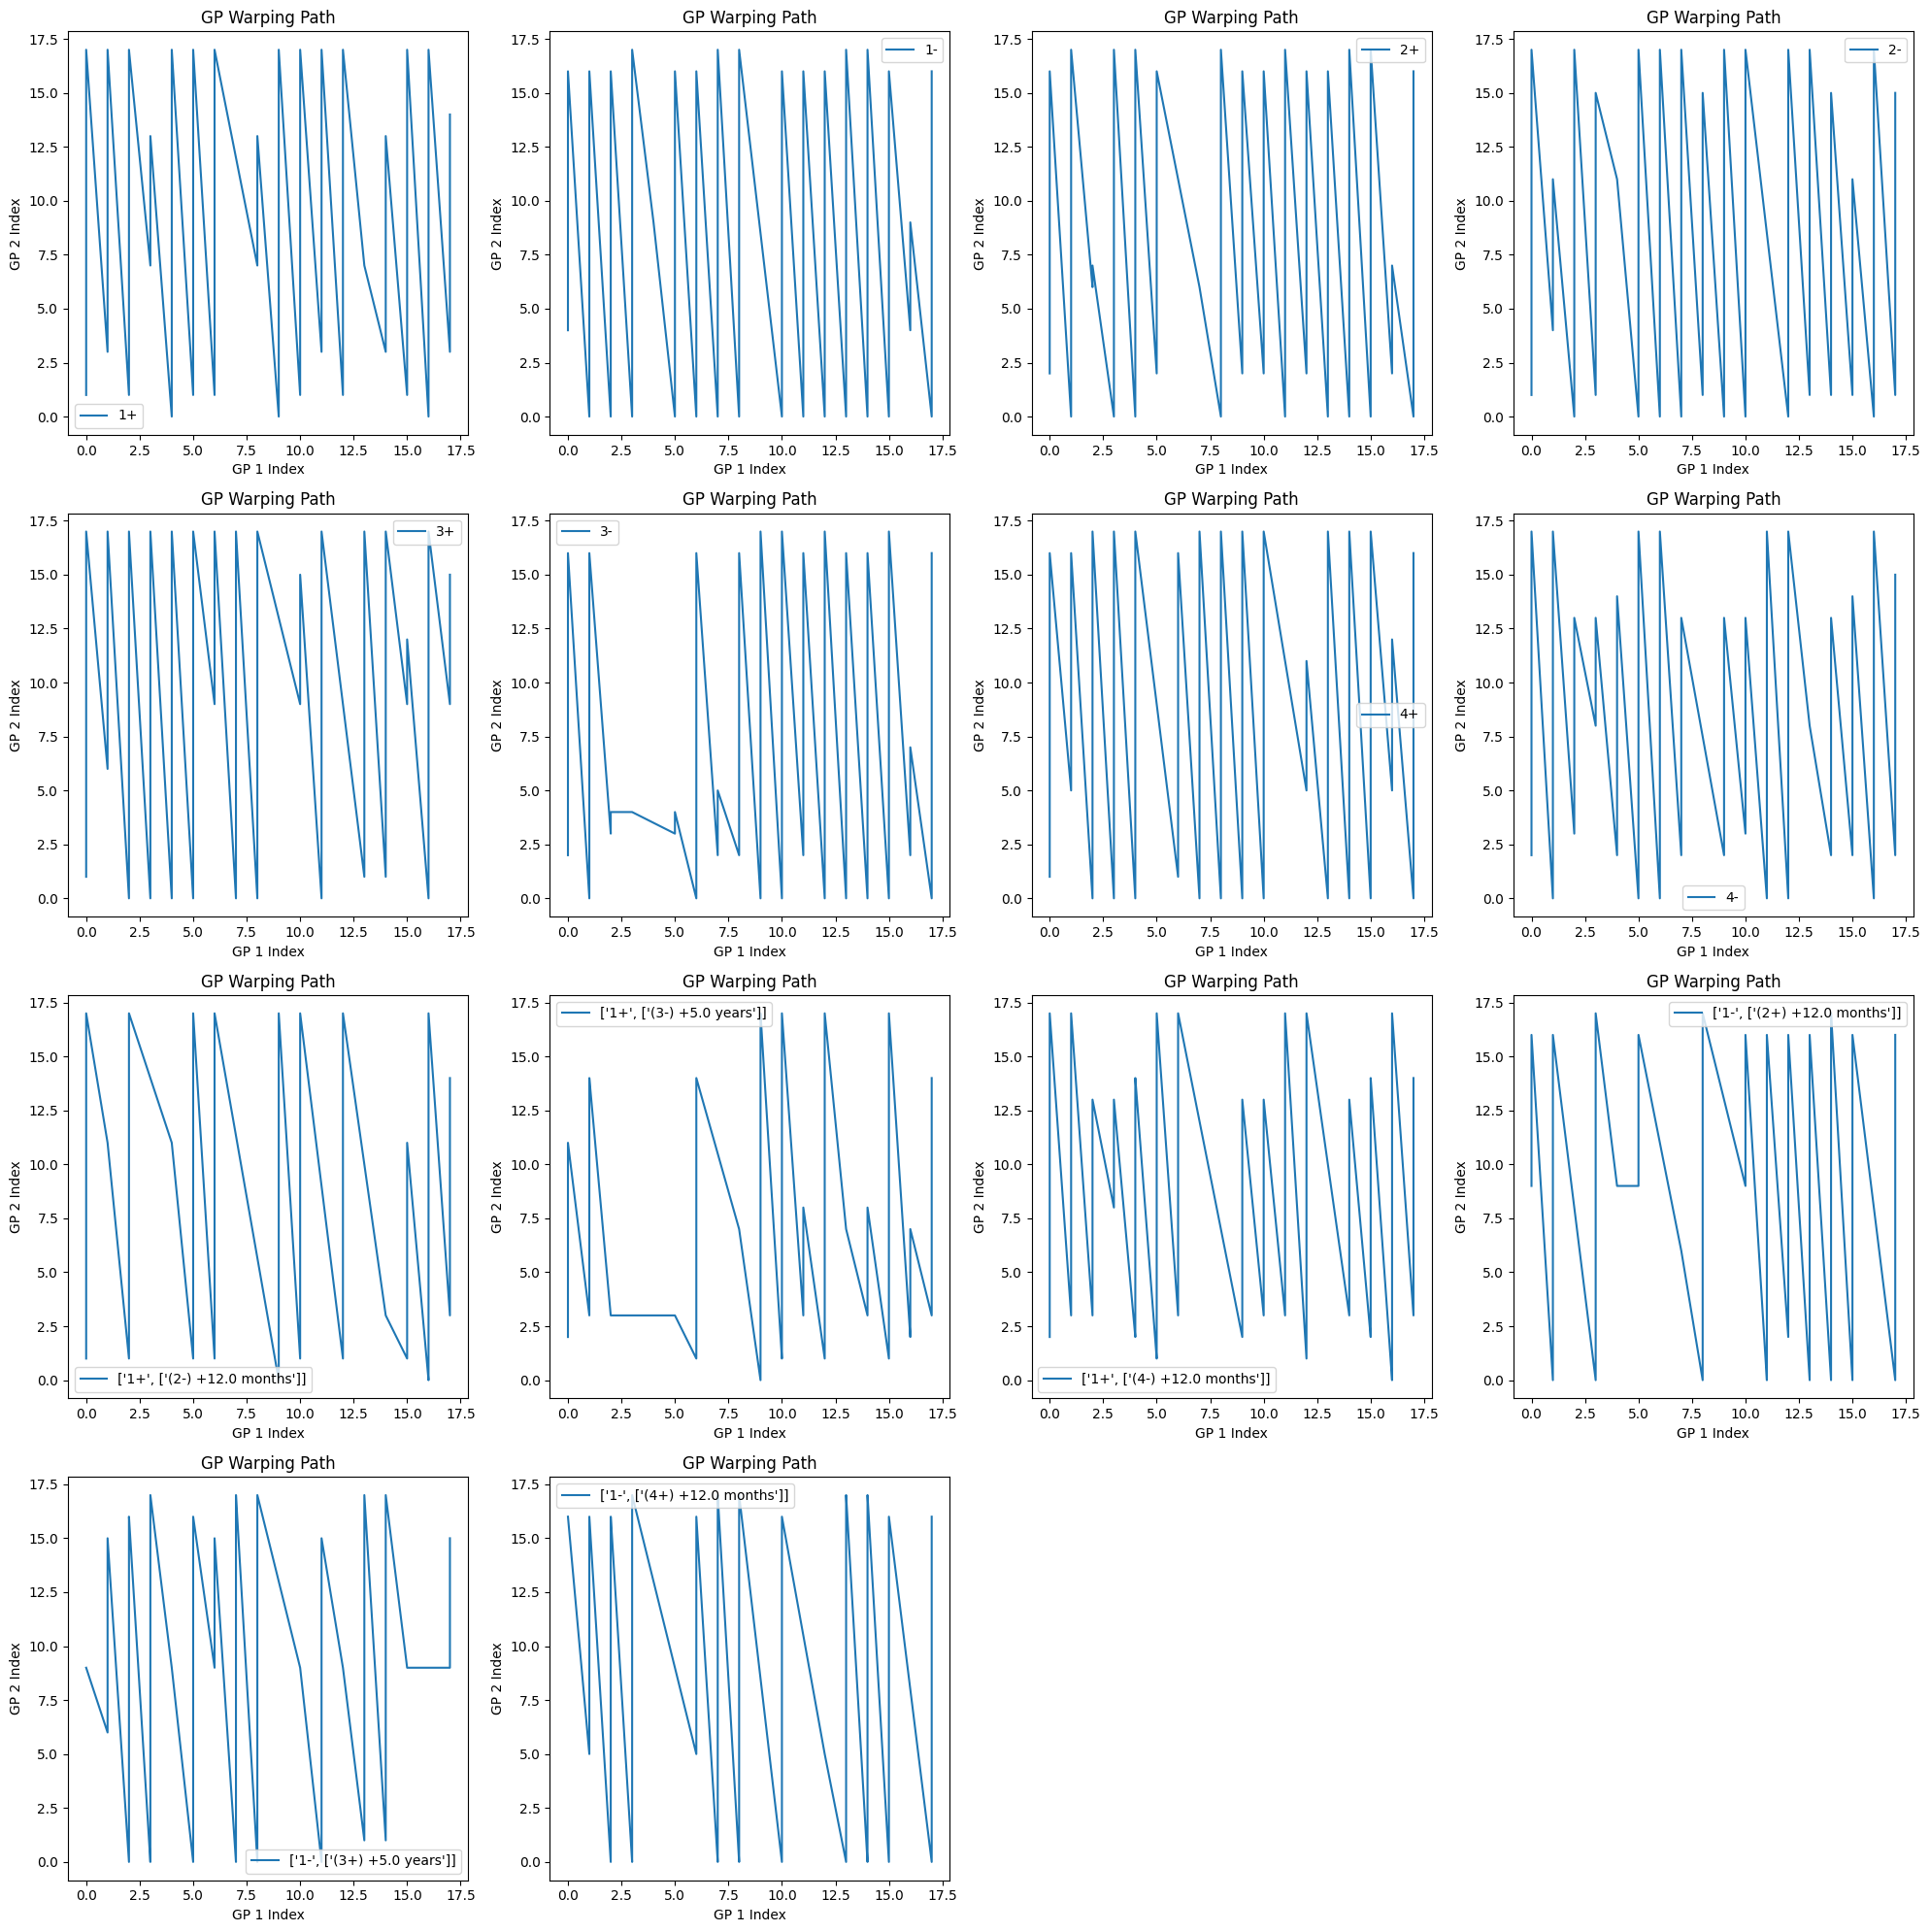

In [16]:
# Calculate the number of rows needed
num_plots = len(gp_components)
cols = 4
rows = math.ceil(num_plots / cols)

# Create subplots with the required number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each component in its subplot
for idx, (key, val) in enumerate(gp_components.items()):
    axes[idx].plot([p[0] for p in val], [p[1] for p in val], '-', label=f"{key}")
    axes[idx].set_xlabel("GP 1 Index")
    axes[idx].set_ylabel("GP 2 Index")
    axes[idx].legend()
    axes[idx].set_title(f"GP Warping Path")

# Hide any extra subplots
for ax in axes[num_plots:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

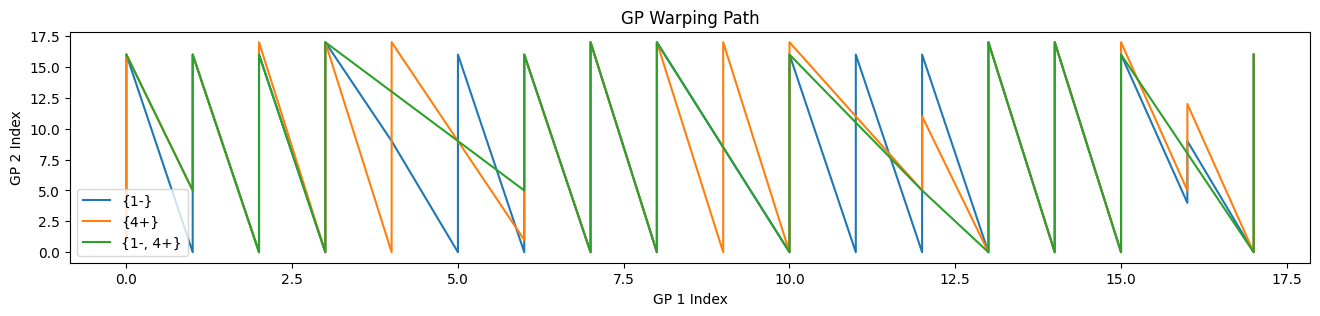

In [19]:
plt.figure(figsize=(16, 3))
plt.plot([p[0] for p in gp_components['1-']], [p[1] for p in gp_components['1-']], '-', label="{1-}")
plt.plot([p[0] for p in gp_components['4+']], [p[1] for p in gp_components['4+']], label="{4+}")
plt.plot([p[0] for p in gp_components["['1-', ['(4+) +12.0 months']]"]], [p[1] for p in gp_components["['1-', ['(4+) +12.0 months']]"]], label="{1-, 4+}")

plt.xlabel('GP 1 Index')
plt.ylabel('GP 2 Index')
plt.title('GP Warping Path')
plt.legend()
plt.show()